In [1]:
import pandas as pd
import numpy
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [2]:
# Read in cleaned data
data = pd.read_excel('./Data/Online Retail_clean.xlsx',
                header = 0)

In [3]:
data.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


___
___

# RFM Analysis
## Recency
- Calculate days since last purchase
- Calculate days between purchases

In [14]:
# Aggregate original data by CustomerID to
# get number of unique Invoices
# and the date of the last invoice
days_since_last = data\
                    .groupby('CustomerID')\
                    .agg({'InvoiceNo':'nunique',
                          'InvoiceDate':'max'})

In [15]:
# Calculate the number of days since last purchase
## Go from Jan 1, 2012 to simulate data analysis 
## on a narrower timescale
days_since_last['day_since_last_purchase'] = (datetime.datetime.strptime('01012012','%m%d%Y') - days_since_last['InvoiceDate']).dt.days

In [16]:
last_invoice = days_since_last.sort_values(['InvoiceNo',
                                             'InvoiceDate'],
                                            ascending = False)\
                                .rename({'InvoiceDate':'LastInvoiceDate',
                                        'InvoiceNo':'NumInvoices'},
                                        axis = 1)

In [17]:
last_invoice

,NumInvoices,LastInvoiceDate,day_since_last_purchase
CustomerID,,,
14911.0,248,2011-12-08 15:54:00,23
12748.0,224,2011-12-09 12:20:00,22
17841.0,169,2011-12-08 12:07:00,23
14606.0,128,2011-12-08 19:28:00,23
15311.0,118,2011-12-09 12:00:00,22
...,...,...,...
16583.0,1,2010-12-01 12:03:00,395
17908.0,1,2010-12-01 11:45:00,395
12791.0,1,2010-12-01 11:27:00,395


## Frequency
- Calculate number of purchases

In [18]:
def days_between_purchases(group):
    # Custom groupby function to get the number of days between purchases
    # Get the InvoiceDate of each order and remove duplicates. Sort by date
    group_sorted = group[['InvoiceDate']]\
                    .drop_duplicates()\
                    .sort_values('InvoiceDate', ascending = True)

    # Calculate the number of days between purchase dates
    group_sorted['days_between_last_purchase'] = (group_sorted['InvoiceDate'] - group_sorted['InvoiceDate'].shift(1)).dt.days

    return group_sorted[['InvoiceDate', 'days_between_last_purchase']]

In [19]:
days_between_purchases = data.groupby('CustomerID')\
                            .apply(days_between_purchases)\
                            .droplevel(1)\
                            .reset_index()

In [20]:
days_between_purchases

,CustomerID,InvoiceDate,days_between_last_purchase
0,12346.0,2011-01-18 10:01:00,NaN
1,12346.0,2011-01-18 10:17:00,0.0
2,12347.0,2010-12-07 14:57:00,NaN
3,12347.0,2011-01-26 14:30:00,49.0
4,12347.0,2011-04-07 10:43:00,70.0
...,...,...,...
22029,18283.0,2011-11-30 12:59:00,6.0
22030,18283.0,2011-12-06 12:02:00,5.0
22031,18287.0,2011-05-22 10:39:00,NaN
22032,18287.0,2011-10-12 10:23:00,142.0


In [21]:
# Aggregate by CustomerID to get the total number of InvoiceDate and the average time between them
avg_days_between = days_between_purchases\
                    .groupby('CustomerID')\
                    .agg({'InvoiceDate':'count',
                          'days_between_last_purchase':'mean'})

In [22]:
avg_days_between.sort_values(['InvoiceDate',
                             'days_between_last_purchase'],
                             ascending = False,
                            inplace = True)

In [23]:
avg_days_between.rename({'InvoiceDate':'NumInvoices',
                         'days_between_last_purchase':'AvgDaysBetweenPurchases'},
                        axis = 1,
                        inplace = True)

## Monetary
- Calculate total amount spent

In [24]:
data['TotalPrice'] = data['Quantity']*data['UnitPrice']

In [25]:
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


In [26]:
customer_total_spent = data.groupby('CustomerID')\
                        [['InvoiceNo','TotalPrice']]\
                        .agg({'InvoiceNo':'nunique',
                              'TotalPrice':'sum'})\
                        .sort_values('TotalPrice',
                                     ascending = False)\
                        .rename({'InvoiceNo':'NumInvoices',
                                 'TotalPrice':'TotalSpend'},
                                axis = 1)

In [27]:
customer_total_spent['AvgSpend'] = customer_total_spent['TotalSpend']/customer_total_spent['NumInvoices']

In [28]:
customer_total_spent

,NumInvoices,TotalSpend,AvgSpend
CustomerID,,,
14646.0,77,279489.02,3629.727532
18102.0,62,256438.49,4136.104677
17450.0,55,187482.17,3408.766727
14911.0,248,132572.62,534.567016
12415.0,26,123725.45,4758.671154
...,...,...,...
12503.0,1,-1126.00,-1126.000000
17603.0,5,-1165.30,-233.060000
14213.0,1,-1192.20,-1192.200000


## Merging RFM

In [29]:
rfm_merge = pd.merge(pd.merge(last_invoice,
                             avg_days_between.drop('NumInvoices',
                                                   axis = 1),
                             how = 'outer',
                             left_index = True,
                             right_index = True),
                    customer_total_spent.drop('NumInvoices',
                                              axis = 1),
                    how = 'outer',
                    left_index = True,
                    right_index = True)

In [30]:
rfm_merge.head()

,NumInvoices,LastInvoiceDate,day_since_last_purchase,AvgDaysBetweenPurchases,TotalSpend,AvgSpend
CustomerID,,,,,,
12346.0,2,2011-01-18 10:17:00,347,0.000000,0.00,0.000000
12347.0,7,2011-12-07 15:52:00,24,60.333333,4310.00,615.714286
12348.0,4,2011-09-25 13:13:00,97,94.000000,1797.24,449.310000
12349.0,1,2011-11-21 09:51:00,40,NaN,1757.55,1757.550000
12350.0,1,2011-02-02 16:01:00,332,NaN,334.40,334.400000


In [32]:
with pd.ExcelWriter('./Data/Online Retail_Analysis.xlsx',
                    mode = 'a',
                   if_sheet_exists = 'replace') as writer:
    rfm_merge.to_excel(writer,
                       sheet_name = 'RFM',
                       index = True)

___
___
# Cohort Retention
- Need first purchase month (create cohorts)
- Calculate month-over-month repeat customers % by first purchase month

In [3]:
first_purchase_date = data\
                        .groupby('CustomerID',
                                dropna = False)\
                        [['InvoiceDate']]\
                        .min()\
                        .rename({'InvoiceDate':'FirstInvoiceDate'},
                                axis = 1)

In [4]:
first_purchase_date['Cohort'] = first_purchase_date['FirstInvoiceDate'].apply(lambda x: datetime.datetime.strftime(x,'%b %Y'))

In [5]:
first_purchase_date.head()

,FirstInvoiceDate,Cohort
CustomerID,,
12346.0,2011-01-18 10:01:00,Jan 2011
12347.0,2010-12-07 14:57:00,Dec 2010
12348.0,2010-12-16 19:09:00,Dec 2010
12349.0,2011-11-21 09:51:00,Nov 2011
12350.0,2011-02-02 16:01:00,Feb 2011


In [6]:
data_cohorts = pd.merge(data,
                        first_purchase_date,
                        how = 'left',
                        left_on = 'CustomerID',
                        right_index = True)

In [7]:
data_cohorts['CohortIndex'] = (data_cohorts['InvoiceDate'].dt.to_period('M') - data_cohorts['FirstInvoiceDate'].dt.to_period('M')).apply(lambda x: x.n)

In [8]:
data_cohorts

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,FirstInvoiceDate,Cohort,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01 08:26:00,Dec 2010,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,Dec 2010,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01 08:26:00,Dec 2010,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,Dec 2010,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,Dec 2010,0
...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-08-18 15:44:00,Aug 2011,4
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-08-18 15:44:00,Aug 2011,4
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-08-18 15:44:00,Aug 2011,4
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-08-18 15:44:00,Aug 2011,4


In [33]:
# Export cohort data to excel
with pd.ExcelWriter('./Data/Online Retail_Analysis.xlsx',
                   mode = 'a',
                   if_sheet_exists = 'replace') as writer:
    data_cohorts.to_excel(writer,
                          sheet_name = 'Cohorts',
                          index = False)                     

In [28]:
# Take out December 2011 due to incomplete data
cohort_retention_values = pd.pivot_table(data_cohorts[data_cohorts['InvoiceDate'] < datetime.datetime.strptime('12-2011','%m-%Y')],
                                         index = 'Cohort',
                                         columns = 'CohortIndex',
                                         values = 'CustomerID',
                                         aggfunc = 'nunique')

In [29]:
cohort_retention_values.index = pd.to_datetime(cohort_retention_values.index,
                                               format = '%b %Y')

In [30]:
cohort_retention_values.sort_index(inplace = True)

In [31]:
cohort_retention_pct = cohort_retention_values.divide(cohort_retention_values.loc[:,0],
                                                      axis = 0)\
                        * 100

In [ ]:
# Export cohort data to excel
with pd.ExcelWriter('./Data/Online Retail_Analysis.xlsx',
                   mode = 'a',
                   if_sheet_exists = 'replace') as writer:
    cohort_retention_pct.to_excel(writer,
                          sheet_name = 'Cohorts Pct',
                          index = False)                     

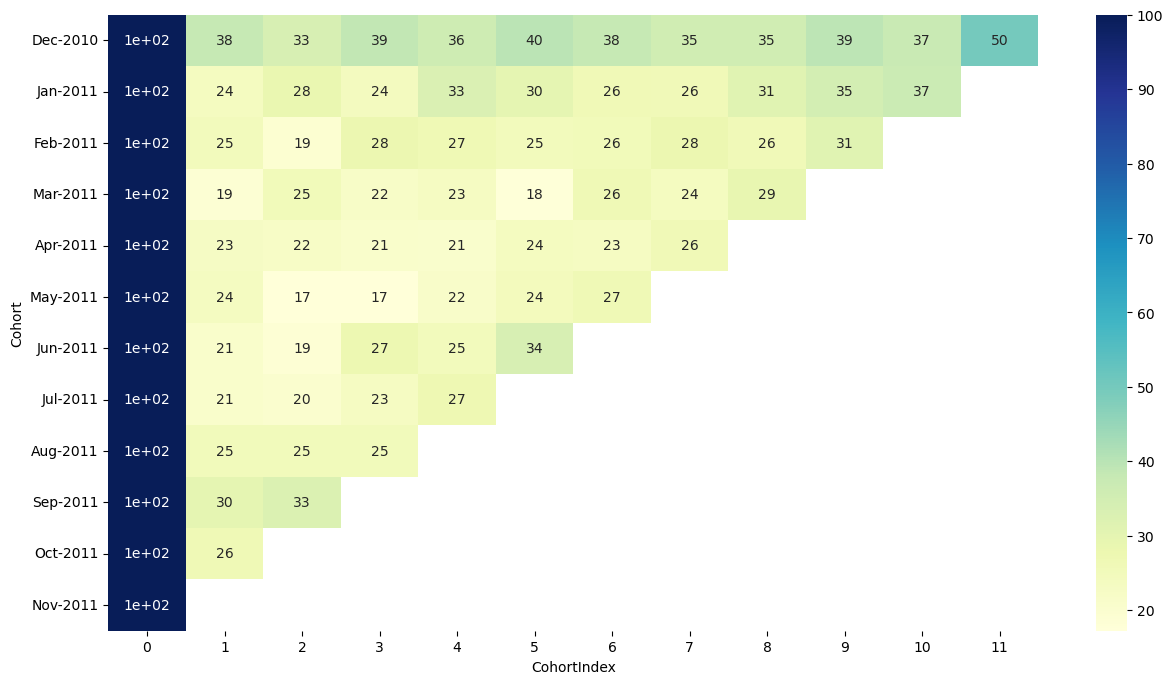

In [32]:
fig, ax = plt.subplots(figsize = (15, 8))
sns.heatmap(cohort_retention_pct,
                 annot = True,
                 cmap = 'YlGnBu',
                ax = ax)

yticklabels = [cohort_retention_pct.index[int(tick)].strftime('%b-%Y')
               for tick in ax.get_yticks()]
ax.set_yticklabels(yticklabels);

In [33]:
cohort_retention_melted = pd.melt(cohort_retention_pct,
                                  ignore_index = False)\
                            .dropna()\
                            .rename({'value':'RetentionRate'},
                                    axis = 1)\
                            .reset_index()

In [34]:
cohort_retention_melted

,Cohort,CohortIndex,RetentionRate
0,2010-12-01,0,100.000000
1,2011-01-01,0,100.000000
2,2011-02-01,0,100.000000
3,2011-03-01,0,100.000000
4,2011-04-01,0,100.000000
...,...,...,...
73,2011-01-01,9,34.679335
74,2011-02-01,9,31.315789
75,2010-12-01,10,37.341772
76,2011-01-01,10,36.817102


<Axes: xlabel='CohortIndex', ylabel='RetentionRate'>

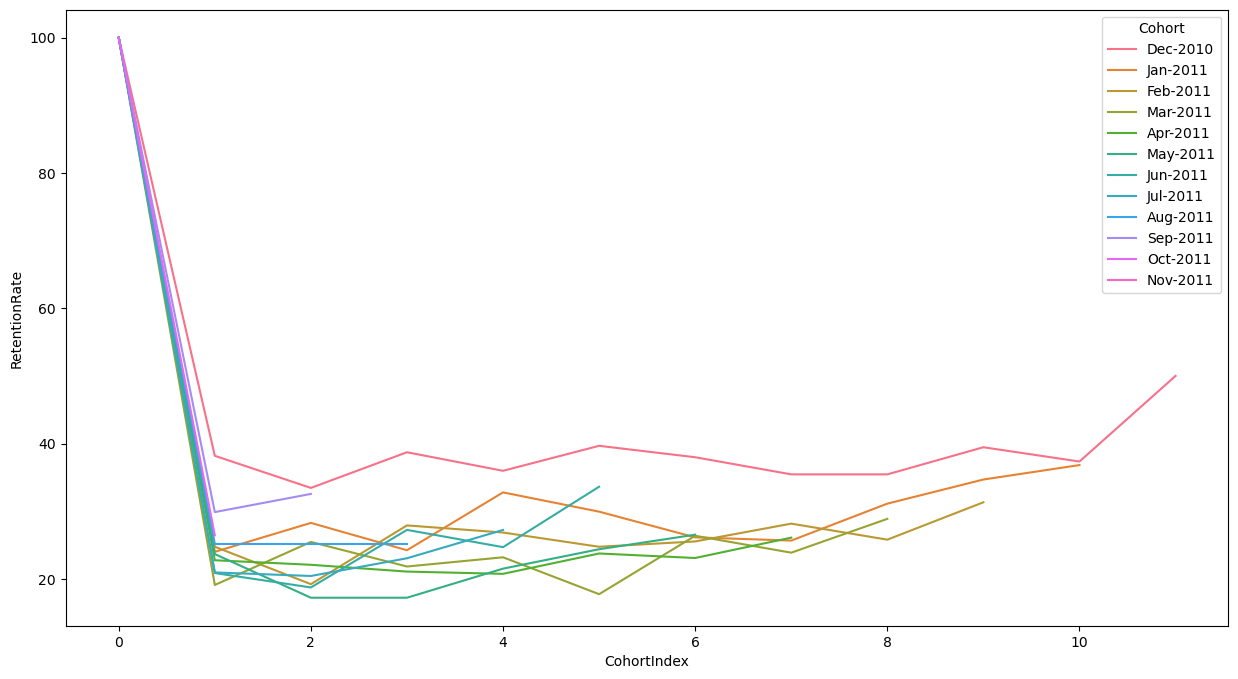

In [35]:
fig, ax = plt.subplots(figsize = (15, 8))
sns.lineplot(cohort_retention_melted,
             x = 'CohortIndex',
             y = 'RetentionRate',
             hue = cohort_retention_melted['Cohort'].dt.strftime('%b-%Y'),
            ax = ax)

# Problem
- ~~Clean and preprocess~~
- ~~Perform RFM analysis (Recency, Frequency, Monetary)~~
- ~~Create cohort retention charts (month-to-moth repeat rate)~~
- Build a Tableau dashboard that lets stakeholders see which customer segments are most profitable